## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import os
import numpy as np 
import pandas as pd 

from glob import glob
import matplotlib.pyplot as plt

In [2]:
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.applications.densenet import DenseNet169
#from keras.applications.xception import Xception
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.layers import (Dense,
                                     Dropout,
                                     Flatten,
                                     GlobalAveragePooling2D)

from keras.callbacks import (ModelCheckpoint,
                             ReduceLROnPlateau,
                             LearningRateScheduler, 
                             EarlyStopping)

Using TensorFlow backend.


In [5]:
%matplotlib inline

## Do some early processing of your metadata for easier model training:

In [6]:
all_xray_df = pd.read_csv('cleaned_data.csv')

In [7]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112104 entries, 0 to 112103
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112104 non-null  object 
 1   Follow-up #                  112104 non-null  int64  
 2   Patient ID                   112104 non-null  int64  
 3   Patient Age                  112104 non-null  int64  
 4   Patient Gender               112104 non-null  object 
 5   View Position                112104 non-null  object 
 6   OriginalImage[Width          112104 non-null  int64  
 7   Height]                      112104 non-null  int64  
 8   OriginalImagePixelSpacing[x  112104 non-null  float64
 9   y]                           112104 non-null  float64
 10  path                         112104 non-null  object 
 11  Atelectasis                  112104 non-null  int64  
 12  Cardiomegaly                 112104 non-null  int64  
 13 

## Create your training and testing data:

In [8]:
def create_splits(df, test_size=0.2, stratify='Pneumonia'):
    
    train_df, val_df = train_test_split(df, test_size=test_size, stratify=df[stratify])
    
    # balancing classes in the training subset
    p_idx = train_df[train_df['Pneumonia']==1].index.tolist()
    np_idx = train_df[train_df['Pneumonia']==0].index.tolist()
    np_samples = sample(np_idx, len(p_idx))
    train_df = train_df.loc[p_idx + np_samples]
    
    # ensuring that Non-Pneumonia cases are 3 times Pneumonia cases in the valid subset (reflecting the real-world)
    p_idx = val_df[val_df['Pneumonia']==1].index.tolist()
    np_idx = val_df[val_df['Pneumonia']==0].index.tolist()
    np_samples = sample(np_idx, 3*len(p_idx))
    val_df = val_df.loc[p_idx + np_samples]
    
    return train_df, val_df

In [9]:
train_df, val_df = create_splits(all_xray_df)

In [10]:
len(train_df[train_df['Pneumonia']==1]) / len(train_df), len(train_df[train_df['Pneumonia']==0]) / len(train_df)

(0.5, 0.5)

In [11]:
len(val_df[val_df['Pneumonia']==1]) / len(val_df), len(val_df[val_df['Pneumonia']==0]) / len(val_df)

(0.25, 0.75)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [12]:
def generate_image_data(train_data = True):

    if train_data:  
        id_gen = ImageDataGenerator(
            rotation_range = 15,
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            brightness_range = (0.8, 1.2),
            zoom_range = 0.1,
            rescale = 1. / 255)
    else:
        id_gen = ImageDataGenerator(rescale = 1. / 255)
    
    return id_gen


def make_train_gen(id_gen, 
                   train_df, 
                   x_col='path',
                   y_col='target', 
                   target_size=(224, 224), 
                   batch_size=32):
    
    train_gen = id_gen.flow_from_dataframe(dataframe = train_df, 
                                         directory = None, 
                                         x_col = x_col,
                                         y_col = y_col,
                                         class_mode = 'binary',
                                         target_size = target_size, 
                                         batch_size = batch_size,
                                         shuffle=True)

    return train_gen



def make_val_gen(id_gen, 
                 val_df, 
                 x_col='path',
                 y_col='target', 
                 target_size=(224, 224), 
                 batch_size=1024):
    
    val_gen = id_gen.flow_from_dataframe(dataframe = val_df, 
                                         directory = None, 
                                         x_col = x_col,
                                         y_col = y_col,
                                         class_mode = 'binary',
                                         target_size = target_size, 
                                         batch_size = batch_size)
    return val_gen

In [13]:
id_gen = generate_image_data()  # generate train data with augmentation
train_gen = make_train_gen(id_gen, train_df)

id_gen =  generate_image_data(train_data = False) # generate validation data with resccaling only
val_gen = make_val_gen(id_gen, val_df)

Found 2288 validated image filenames belonging to 2 classes.
Found 1144 validated image filenames belonging to 2 classes.


In [14]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

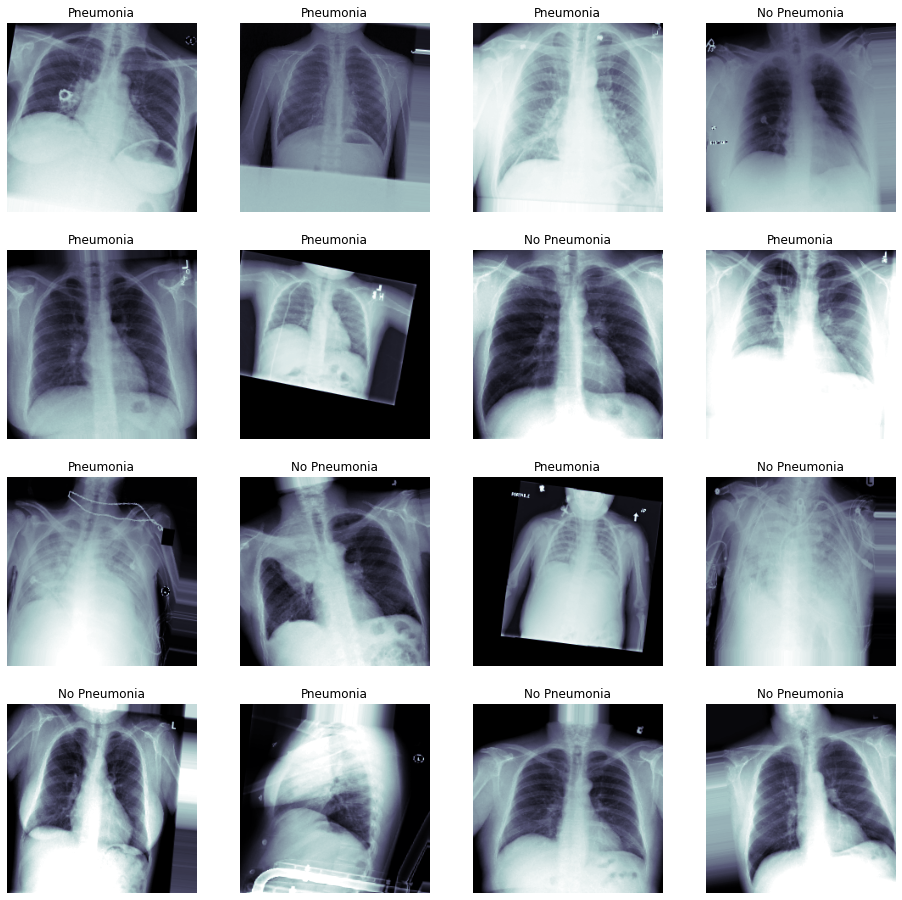

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [16]:
def load_pretrained_mobilenetv2(image_size=(224, 224, 3)):
    """
    Load a pre-trained MobileNetV2 model with weights from ImageNet.
    
    Args:
        image_size (tuple): Input image size in the format (height, width, channels).
        
    Returns:
        tf.keras.Model: Pre-trained MobileNetV2 model.
    """
    
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=image_size)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    mobilenetv2_model = Model(inputs=base_model.input, outputs=base_model.output)
    
    return mobilenetv2_model

In [19]:
def build_custom_model(base_model):
    """
    Build a custom classification model on top of a base model.
    
    Args:
        base_model (tf.keras.Model): Base model to build upon.
        
    Returns:
        tf.keras.Model: Custom classification model.
    """
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [18]:
base_mobilenetv2 = load_pretrained_mobilenetv2()

9412608/9406464 [==============================] - 0s 0us/step


In [20]:
base_mobilenetv2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [21]:
custom_model = build_custom_model(base_mobilenetv2)

In [22]:
custom_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

In [23]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)


lr_reducer = ReduceLROnPlateau(factor=0.1,
                               patience=5,
                               cooldown=5,
                               min_lr=0.1e-6, verbose=1)


early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=10,
                           verbose=1,
                           mode="auto",
                           baseline=None,
                           restore_best_weights=True)


callbacks_list = [checkpoint, lr_reducer, early_stop]

In [23]:
# TO CHECK

#def step_decay(epoch):
#    initial_lrate = 1e-4
#    drop = 0.5
#    epochs_drop = 10.0
#    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#    return lrate
#
#callbacks_list = [checkpoint, early, LearningRateScheduler(step_decay, verbose=1)]

### Start training! 

In [24]:
## compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = 'binary_crossentropy'
metrics=['binary_accuracy']

custom_model.compile(
            optimizer = optimizer,
            loss = loss,
            metrics = metrics)
    
    
# train the model
history = custom_model.fit(train_gen, 
                               validation_data = (valX, valY), 
                               epochs = 60, 
                               callbacks = callbacks_list)

  ...
    to  
  ['...']
Train for 72 steps, validate on 1024 samples
Epoch 1/60
71/72 [============================>.] - ETA: 0s - loss: 0.7429 - binary_accuracy: 0.5275
Epoch 00001: val_loss improved from inf to 0.64052, saving model to xray_class_my_model.best.hdf5
72/72 [==============================] - 74s 1s/step - loss: 0.7414 - binary_accuracy: 0.5288 - val_loss: 0.6405 - val_binary_accuracy: 0.6621
Epoch 2/60
71/72 [============================>.] - ETA: 0s - loss: 0.7068 - binary_accuracy: 0.5585
Epoch 00002: val_loss improved from 0.64052 to 0.55310, saving model to xray_class_my_model.best.hdf5
72/72 [==============================] - 63s 879ms/step - loss: 0.7075 - binary_accuracy: 0.5581 - val_loss: 0.5531 - val_binary_accuracy: 0.7529
Epoch 3/60
71/72 [============================>.] - ETA: 0s - loss: 0.6894 - binary_accuracy: 0.5754
Epoch 00003: val_loss did not improve from 0.55310
72/72 [==============================] - 62s 861ms/step - loss: 0.6884 - binary_accurac

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [25]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
custom_model.load_weights(weight_path)
pred_Y = custom_model.predict(valX, batch_size = 32, verbose = True)

1024/1024 [==============================] - 3s 3ms/sample


In [26]:
def plot_auc(y_true, y_pred):
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    
    plt.plot([0, 1], [0, 1], 'y--')
    plt.plot(fpr, tpr, marker='.', label=f'Pneumonia (AUC: {auc_score:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC')
    plt.legend(loc="lower right")
    plt.show()


def plot_history(history):  
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower right")
    plt.show()

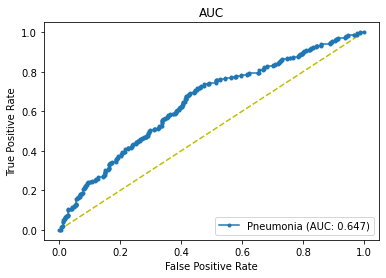

In [27]:
# plot auc
plot_auc(valY, pred_Y)

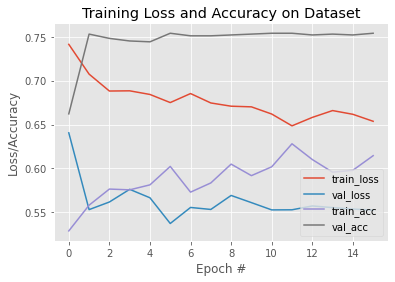

In [28]:
# plot history
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [29]:
# utils
def generate_thresholds(y_pred):
    """
    Generate a set of classification thresholds based on predicted probabilities.

    This function computes a collection of classification thresholds utilizing a two-part
    approach. The initial set of thresholds is extracted from the unique predicted probabilities
    (`y_pred`), akin to the methodology found in the precision-recall curve implementation within
    the `sklearn.metrics` module. Furthermore, the function augments this set by incorporating
    additional thresholds at 5% intervals between 5% and 95%.

    Parameters:
        y_pred (numpy.ndarray): An array containing the predicted probabilities.

    Returns:
        numpy.ndarray: A sorted array comprising the generated classification thresholds.

    Example:
        >>> predicted_probs = np.array([0.2, 0.5, 0.7, 0.3, 0.8])
        >>> thresholds = generate_thresholds(predicted_probs)
        >>> print(thresholds)
        [0.2 0.3 0.5 0.7 0.8 ... 0.95 1.0]
    """

    thresholds = np.unique(np.concatenate([y_pred, np.arange(0.05, 1., 0.05)]))
    return np.sort(thresholds)

def compute_tp_tn_fp_fn(y_true, y_pred):
    tp = (y_true == 1) & (y_pred == 1)
    tn = (y_true == 0) & (y_pred == 0)
    fp = (y_true == 0) & (y_pred == 1)
    fn = (y_true == 1) & (y_pred == 0)

    return tp.astype(int), tn.astype(int), fp.astype(int), fn.astype(int)

def compute_accuracy(y_true, y_pred):
    tp, tn, fp, fn = compute_tp_tn_fp_fn(y_true, y_pred)
 
    # check for NaN or infinity values
    if np.isnan(tp).any() or np.isnan(tn).any() or np.isnan(fp).any() or np.isnan(fn).any():
        print("Invalid values found in tp or fp arrays.")

    # Check for division by zero
    if np.sum(tp + tn + fp + fn) == 0:
        print("Division by zero detected.")

    accuracy = np.sum(tp + tn) / (np.sum(tp + tn + fp + fn) + np.finfo(float).eps)  # Adding epsilon to avoid division by zero
    return accuracy

def compute_precision(y_true, y_pred):
    tp, _, fp, _ = compute_tp_tn_fp_fn(y_true, y_pred)

    # check for NaN or infinity values
    if np.isnan(tp).any() or np.isnan(fp).any():
        print("Invalid values found in tp or fp arrays.")

    # Check for division by zero
    if np.sum(tp + fp) == 0:
        print("Division by zero detected.")
    
    precision = np.sum(tp) / (np.sum(tp + fp) + np.finfo(float).eps)  # Adding epsilon to avoid division by zero
    return precision

def compute_recall(y_true, y_pred):
    tp, *_, fn = compute_tp_tn_fp_fn(y_true, y_pred) 
    
    # check for NaN or infinity values
    if np.isnan(tp).any() or np.isnan(fn).any():
        print("Invalid values found in tp or fn arrays.")

    # Check for division by zero
    if np.sum(tp + fn) == 0:
        print("Division by zero detected.")

    recall = np.sum(tp) / (np.sum(tp + fn) + np.finfo(float).eps)
    return recall

def compute_specificity(y_true, y_pred):
    _, tn, fp, _ = compute_tp_tn_fp_fn(y_true, y_pred)
    
    # check for NaN or infinity values
    if np.isnan(tn).any() or np.isnan(fp).any():
        print("Invalid values found in tn or fp arrays.")

    # Check for division by zero
    if np.sum(tn + fp) == 0:
        print("Division by zero detected.")
 
    specificity = np.sum(tn) / (np.sum(tn + fp) + np.finfo(float).eps)
    return specificity

def compute_f1_score(y_true, y_pred):
    precision = compute_precision(y_true, y_pred)
    recall = compute_recall(y_true, y_pred)

    # Check for division by zero
    if np.sum(precision + recall) == 0:
        print("Division by zero detected.")
 
    f1_score = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)
    return f1_score

In [44]:
from sklearn.metrics import accuracy_score, precision_score

In [51]:
def compute_metrics(y_true, y_pred, thresholds):
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'specificity': []
    }
    for thresh in thresholds:
        y_pred_thresh = (y_pred >= thresh).astype(int)
        metrics['accuracy'].append(accuracy_score(y_true, y_pred_thresh))
        metrics['precision'].append(precision_score(y_true, y_pred_thresh))
        metrics['recall'].append(compute_recall(y_true, y_pred_thresh))
        metrics['f1_score'].append(compute_f1_score(y_true, y_pred_thresh))
        metrics['specificity'].append(compute_specificity(y_true, y_pred_thresh))
    return metrics


def plot_metrics(metrics, thresholds):
    metric_names = list(metrics.keys())
    for metric_name in metric_names:
        plt.plot(thresholds, metrics[metric_name], label=metric_name)

    plt.title("Performance Metrics")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [52]:
# generate thresholds
thresholds = generate_thresholds(pred_Y[:, 0])

In [53]:
# compute metrics
computed_metrics = compute_metrics(valY, pred_Y[:, 0], thresholds)

Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.


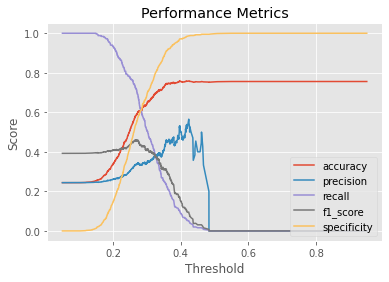

In [54]:
# plot metrics
plot_metrics(computed_metrics, thresholds)

In [57]:
# best accuracy for f1 score 
f1_scores = dict([(thresh, compute_f1_score(valY, (pred_Y[:, 0] >= thresh).astype(int))) for thresh in thresholds])
best_thresh = max(f1_scores, key=f1_scores.get)
print(f'\nbest_threshold = {best_thresh}, score = {f1_scores[best_thresh]}')

Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.
Division by zero detected.

best_threshold = 0.2692889869213104, score = 0.45956354300385094


In [58]:
# test with f1_score metric from sklearn.metrics
from sklearn.metrics import f1_score

f1_scores = dict([(thresh, f1_score(valY, (pred_Y[:, 0] >= thresh).astype(int))) for thresh in thresholds])
best_thresh = max(f1_scores, key=f1_scores.get)
print(f'best_threshold = {best_thresh}, score = {f1_scores[best_thresh]}')

best_threshold = 0.2692889869213104, score = 0.45956354300385105


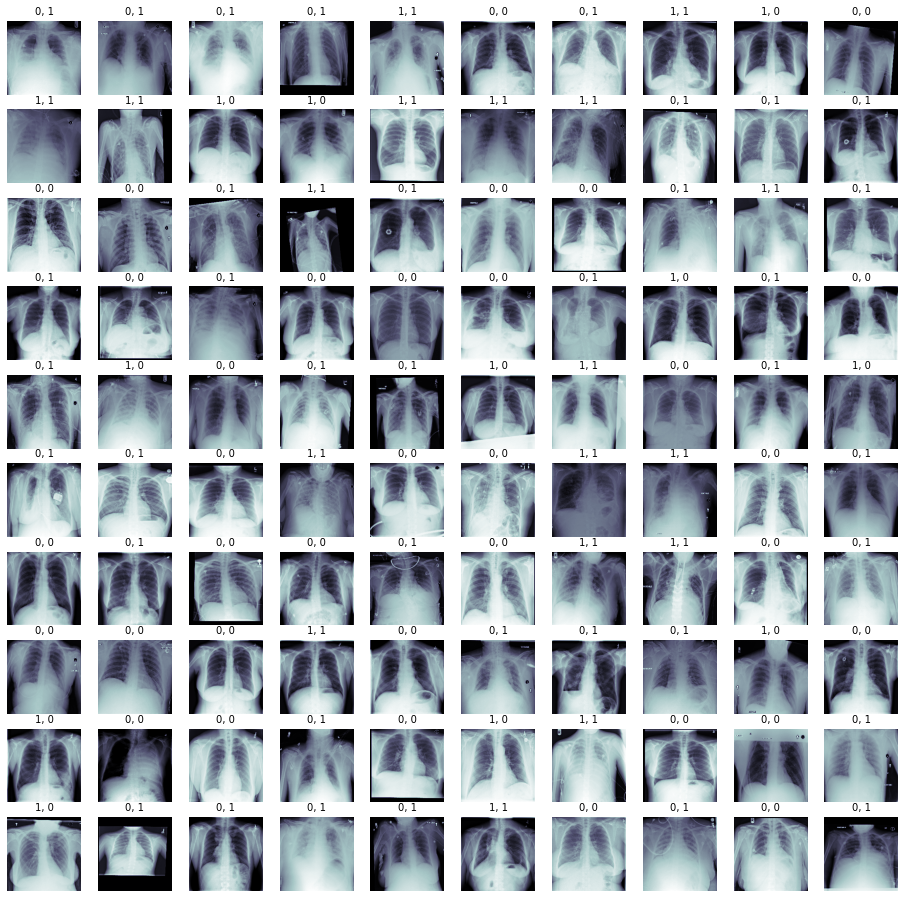

In [64]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > best_thresh:
             c_ax.set_title('1, 1', fontsize=10)
        else:
             c_ax.set_title('1, 0', fontsize=10)
    else:
        if pred_Y[i] > best_thresh: 
             c_ax.set_title('0, 1', fontsize=10)
        else:
             c_ax.set_title('0, 0', fontsize=10)
    c_ax.axis('off')
    i=i+1



In [66]:
## Just save model architecture to a .json:

model_json = custom_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)